In [17]:
import boto3
import io
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
import yaml
import progressbar
import uuid
import numpy as np

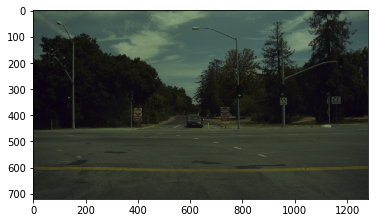

In [11]:
s3 = boto3.resource('s3')

bucket_name = "capstone-trafficlights"
key = 'rgb/train/2015-05-29-15-29-39_arastradero_traffic_light_loop_bag/10648.png'
bucket = s3.Bucket(bucket_name)
image_obj = s3.Object(bucket_name, key)
image = io.BytesIO(image_obj.get()['Body'].read())
image = Image.open(image)
plt.imshow(image)
plt.show()

# Load All Data from yaml file

In [31]:
with open("./train.yaml", 'r') as stream:
    try:
        all_train_data = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
count_boxes = 0
for data in all_train_data:
    if len(data['boxes']) >0:
        for box in data['boxes']:
            count_boxes+=1
print("#{} of Boxes".format(count_boxes))

#10756 of Boxes


# Experiment with data

In [37]:
count = 0
font = ImageFont.truetype("sg-alternative.high-alt.otf", 20)
accepted_labels = {"Green":0, "Red":0, "Yellow":0}
ignore_labels={"GreenLeft":0, "GreenRight":0, "RedLeft":0, "RedRight":0, "YellowLeft":0, "YellowRight":0, "off":0}
other_labels={}
max_count = count_boxes
csv_classes="path,label"
with progressbar.ProgressBar(max_value=max_count) as bar:
    with open('csv_classes.csv','w') as csv_classes:
        csv_classes.write("path,label")
        for data in all_train_data:
            if len(data['boxes']) >0:
                key = data['path'][2:]
                image_obj = s3.Object(bucket_name, key)
                image = io.BytesIO(image_obj.get()['Body'].read())
                image = Image.open(image)
                draw = ImageDraw.Draw(image)
                for box in data['boxes']:
                    box_height = box['y_max'] - box['y_min'] 
                    box_width = box['x_max'] - box['x_min'] 
                    if box_height * box_width > 100:
                        if box['label'] in accepted_labels.keys():
                            img_cropped = image.crop((box['x_min'], box['y_min'], box['x_max'], box['y_max']))

                            if box['label'] == "Red":
                                accepted_labels['Red']+=1
                            elif box['label'] == 'Yellow':
                                accepted_labels['Yellow']+=1
                            elif box['label'] == 'Green':
                                accepted_labels['Green']+=1
                            image_id = uuid.uuid4().hex
                            image_key = 'processed_train_set/{}.png'.format(image_id)
                            imgByteArr = io.BytesIO()
                            img_cropped.save(imgByteArr, format='PNG')
                            imgByteArr = imgByteArr.getvalue()
                            s3.Bucket(bucket_name).put_object(Key=image_key, Body=imgByteArr)
                            csv_classes.write("\n{},{}".format(image_key, box['label']))
            #                 draw.rectangle(((box['x_min'],box['y_min'] ), (box['x_max'],box['y_max'])), fill=None, outline=(255, 0, 0))
            #                 draw.text((box['x_min']-20,box['y_min']-20),box['label'],(255,0,0), font=font)
            #                 draw.text((box['x_min']-80,box['y_min']-20),str(int(box_height * box_width)),(255,0,0), font=font)

        #                     plt.figure(figsize=(5,5))
        #                     plt.imshow(img_cropped)
        #                     plt.show()
        #                     print('---')
                        elif box['label'] in ignore_labels.keys():
                            ignore_labels[box['label']]+=1
                        else:
                            if box['label'] not in other_labels.keys():
                                other_labels[box['label']]=0
                            else:
                                other_labels[box['label']]+=1
                    count+=1
                    bar.update(count)

        
print('Data Set Stats: ')
print('Traffic Lights: ', accepted_labels)
print('Ignore Lights: ', ignore_labels)
print('Other Lights: ', other_labels)


100% (10756 of 10756) |###################| Elapsed Time: 0:09:09 Time: 0:09:09


Data Set Stats: 
Traffic Lights:  {'Green': 3560, 'Red': 1673, 'Yellow': 207}
Ignore Lights:  {'GreenLeft': 150, 'GreenRight': 9, 'RedLeft': 965, 'RedRight': 2, 'YellowLeft': 0, 'YellowRight': 0, 'off': 377}
Other Lights:  {'GreenStraight': 9, 'GreenStraightRight': 0, 'RedStraight': 4, 'GreenStraightLeft': 0}
